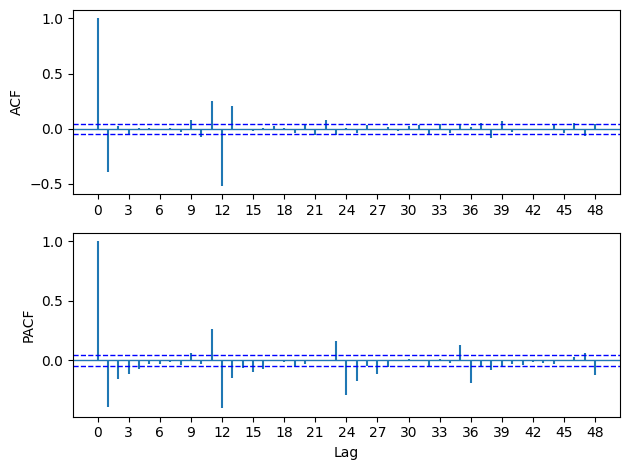

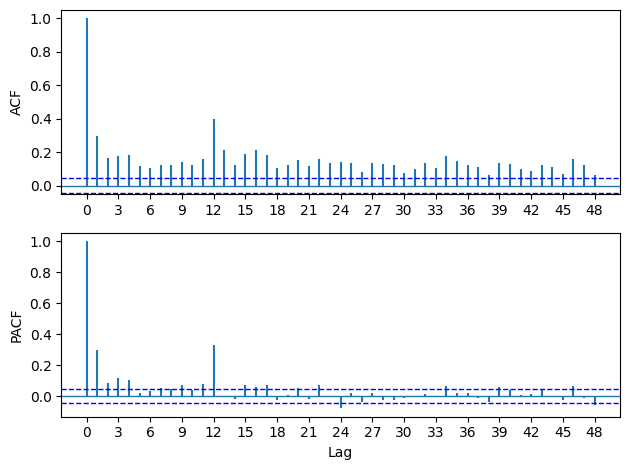

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     839.3
Date:                Wed, 25 Jun 2025   Prob (F-statistic):               0.00
Time:                        08:31:14   Log-Likelihood:                 755.80
No. Observations:                1896   AIC:                            -1502.
Df Residuals:                    1891   BIC:                            -1474.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3240      0.006    -57.835      0.0

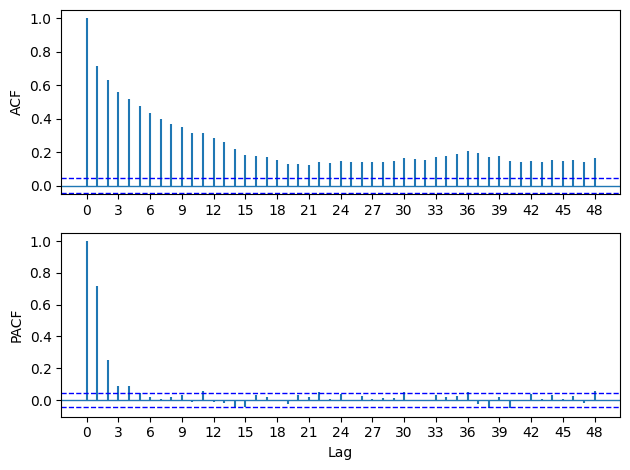

                                          SARIMAX Results                                          
Dep. Variable:                                           y   No. Observations:                 1896
Model:             SARIMAX(1, 0, [1, 3])x([3], 0, [3], 12)   Log Likelihood                1526.821
Date:                                     Wed, 25 Jun 2025   AIC                          -3041.642
Time:                                             08:31:33   BIC                          -3008.357
Sample:                                         01-31-1850   HQIC                         -3029.388
                                              - 12-31-2007                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9163      0.013     72.69

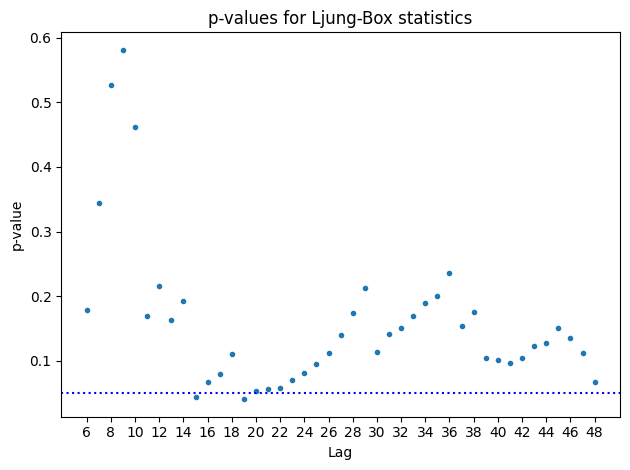

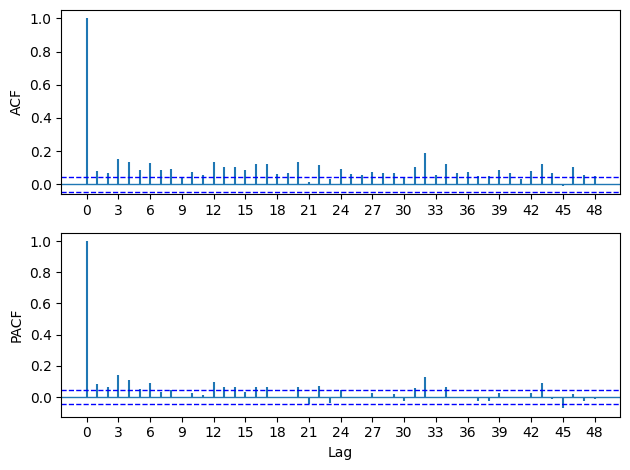

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:                1679.18
Distribution:      Standardized Student's t   AIC:                          -3326.35
Method:                  Maximum Likelihood   BIC:                          -3237.59
                                              No. Observations:                 1896
Date:                      Wed, Jun 25 2025   Df Residuals:                     1896
Time:                              08:31:39   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

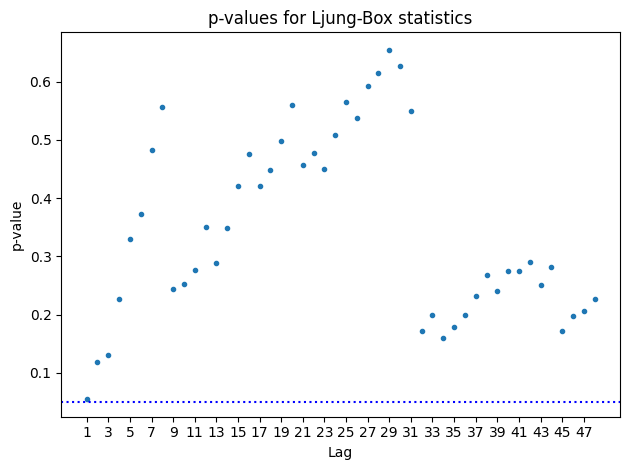

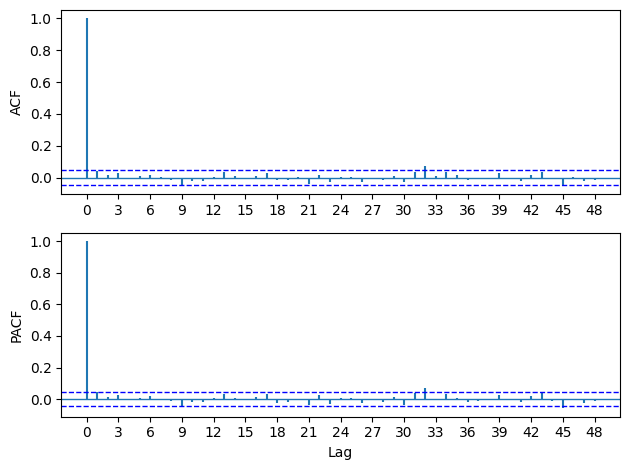

In [6]:
! pip install PythonTsa arch


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from PythonTsa.LjungBoxtest import plot_LB_pvalue
from statsmodels.tsa.statespace.sarimax import SARIMAX
from PythonTsa.datadir import getdtapath
from arch.univariate import arch_model
import math

# Load and prepare the dataset
url = "https://raw.githubusercontent.com/QuantLet/pyTSA/40314998b5b881d3497f2da2d3f82d625b657549/pyTSA_TemperatureSH/Southtemperature.txt"
tem = pd.read_csv(url, header=None, delim_whitespace=True)
temts = pd.concat([tem.loc[0], tem.loc[1]], ignore_index=True)
for i in range(2, 158):
    temts = pd.concat([temts, tem.loc[i]], ignore_index=True)
dates = pd.date_range('1850', periods=len(temts), freq='M')
temts.index = dates

# Differencing
Ddt = sm.tsa.statespace.tools.diff(temts, k_diff=1, k_seasonal_diff=1, seasonal_periods=12)
acf_pacf_fig(Ddt, both=True, lag=48)
plt.tight_layout()
plt.savefig("acf_pacf_differenced_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# ACF of squared differenced data
acf_pacf_fig(Ddt**2, both=True, lag=48)
plt.tight_layout()
plt.savefig("acf_pacf_squared_differenced_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Harmonic seasonal regression variables
COS = np.zeros((len(temts), 6))
SIN = np.zeros((len(temts), 6))
tim = np.zeros(len(temts))
for i in range(158):
    for j in range(12):
        tim[i * 12 + j] = 1850.0 + i + j / 12.0
pi = math.pi
for i in range(6):
    COS[:, i] = np.cos(2 * pi * (i + 1) * tim)
    SIN[:, i] = np.sin(2 * pi * (i + 1) * tim)
TIME = (tim - np.mean(tim)) / np.sqrt(np.var(tim))
t2 = TIME**2
t3 = TIME**3
X = np.column_stack((TIME, t2, t3, SIN[:, 1]))
X = sm.add_constant(X)

# OLS regression
OLSmodel = sm.OLS(temts, X).fit()
print(OLSmodel.summary())
OLSresid = OLSmodel.resid

# KPSS test
print(kpss(OLSresid, regression='c', nlags='auto'))
acf_pacf_fig(OLSresid, both=True, lag=48)
plt.tight_layout()
plt.savefig("acf_pacf_OLSresid_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# SARIMA model on residuals
sarima_model = SARIMAX(OLSresid, order=(1, 0, [1, 3]), seasonal_order=([3], 0, [3], 12), trend='n').fit(disp=False)
print(sarima_model.summary())
sarmaResid = sarima_model.resid
plot_LB_pvalue(sarmaResid, noestimatedcoef=5, nolags=48)
plt.tight_layout()
plt.savefig("LB_pvalue_sarma_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()
acf_pacf_fig(sarmaResid**2, both=True, lag=48)
plt.tight_layout()
plt.savefig("acf_pacf_squared_sarmaResid_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# GARCH model
garchmod = arch_model(sarmaResid, p=6, q=8, mean='Zero', dist="StudentsT").fit(disp='off')
print(garchmod.summary())
garchresid = garchmod.std_resid
plot_LB_pvalue(garchresid**2, noestimatedcoef=0, nolags=48)
plt.tight_layout()
plt.savefig("LB_pvalue_garch_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()
acf_pacf_fig(garchresid**2, both=True, lag=48)
plt.tight_layout()
plt.savefig("acf_pacf_squared_garchresid_Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Save summary chart placeholder
fig = plt.figure(figsize=(10, 1))
plt.text(0.5, 0.5, 'ARCH modeling summary completed', fontsize=16, ha='center', va='center')
plt.axis('off')
plt.savefig("Prob65.png", dpi=300, bbox_inches='tight', transparent=True)
plt.close()

